# DARNet for power load forecasting

- [x] 消融实验，没有CNN2D部分

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

In [2]:
def random_seed_set(seed):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## load data

In [3]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## normalization

In [4]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [5]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to RNN
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len, dim_1))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len]
    print("supervised data: shape of x: {}, shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [6]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## DARNet model

### CNN1D-RNN Block

In [7]:
class CNN1D_RNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout, kernel_size=3):
        super(CNN1D_RNN_Block, self).__init__()
        # params
        padding = int(kernel_size / 2)

        # layers
        self.CNN = nn.Conv1d(in_channels,
                             out_channels,
                             kernel_size,
                             padding=padding)
        self.RNN1 = nn.GRU(input_size=out_channels,
                           hidden_size=out_channels,
                           num_layers=2,
                           dropout=dropout,
                           batch_first=True)
        self.RNN2 = nn.GRU(input_size=in_channels,
                           hidden_size=out_channels,
                           num_layers=2,
                           dropout=dropout,
                           batch_first=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        '''
        x shape (batch_size, seq_len, d_feature)
        '''
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        cnn_input = x.permute(0, 2, 1)
        # cnn_input shape (batch_size, in_channel, seq_len)
        cnn_out = self.CNN(cnn_input)
        # cnn_out = self.bn1(cnn_out)
        cnn_out = self.relu(cnn_out)
        # cnn_out shape (batch_size, out_channel, seq_len)

        rnn_input = cnn_out.permute(0, 2, 1)
        # rnn_input shape (batch_size, seq_len, out_channels)
        rnn_out_1, _ = self.RNN1(rnn_input)
        # rnn_out_1 shape (batch_size, seq_len, out_channels)

        rnn_out_2, _ = self.RNN2(x)
        # rnn_out_2 shape (batch_size, seq_len, out_channels)

        out = self.relu(rnn_out_1 + rnn_out_2)
        return out

### RNN-CNN2D Block

In [8]:
class RNN_CNN2D_Block(nn.Module):
    def __init__(self, input_size, out_channels, seq_len, dropout, n_layers=2):
        super(RNN_CNN2D_Block, self).__init__()

        # layers
        self.RNN = nn.GRU(input_size=input_size,
                          hidden_size=out_channels,
                          num_layers=n_layers,
                          dropout=dropout,
                          batch_first=True)
        self.CNN = nn.Conv2d(in_channels=1,
                             out_channels=out_channels,
                             kernel_size=(seq_len, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        '''
        x shape (batch_size, seq_len, input_size)
        '''
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        rnn_out, hidden_state = self.RNN(x)
        # rnn_out shape (batch_size, seq_len, d_features)

        cnn_input = rnn_out.unsqueeze(1)
        # cnn_input shape (batch_size, 1, seq_len, d_featues)
        cnn_out = self.CNN(cnn_input)
        # cnn_out shape (batch_size, out_channels, 1, d_features)
        cnn_out = cnn_out.squeeze(2).permute(0, 2, 1)
        # cnn_out = self.bn2(cnn_out)
        cnn_out = self.relu(cnn_out)
        
        # cnn_out shape (batch_size, d_features, out_channels)

        return cnn_out, hidden_state

### Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, num_channels, seq_len, dropout=0.5):
        super(Encoder, self).__init__()
        '''
        input_size(int): dimension of features
        num_channels(list): channels of each cnn-rnn layer
        seq_len(int): window length of input
        '''
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_channels = input_size if i==0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [CNN1D_RNN_Block(in_channels, out_channels, dropout)]
    
        self.cnn_rnn = nn.Sequential(*layers)
        self.rnn_cnn = RNN_CNN2D_Block(input_size, num_channels[-1], seq_len, dropout=0)
    
    def forward(self, x, rho):
        '''
        x shape (batch_size, seq_len, input_size)
        '''
        features = x[:, :, :-1]
        values = x[:, :, -1]
        # features shape (batch_size, num_steps, input_size -1)
        # values shape (batch_size, num_steps)

        values_mean = torch.mean(values, dim=1)
        # values_mean shape (batch_size)
        values = torch.cat((values_mean.unsqueeze(1), values), dim=1)
        # values shape (batch_size, num_steps + 1)
        values = values[:, 1:] - rho * values[:, :-1]
        # values shape (batch_size, num_steps)
        inp = torch.cat((features, values.unsqueeze(2)), dim=2)
        # inp shape (batch_size, num_steps, input_size)
        
        cnn_rnn_out = self.cnn_rnn(inp)
        # cnn_rnn_out shape (batch_size, seq_len, num_channels[-1])
        
        rnn_cnn_out, hidden_state = self.rnn_cnn(inp)
        # rnn_cnn_out shape (batch_size, num_channels[-1], num_channels[-1])
        
        return cnn_rnn_out, rnn_cnn_out, hidden_state

### Attention

In [10]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # `queries` 的形状：(`batch_size`，查询的个数，1，`num_hidden`)
        # `key` 的形状：(`batch_size`，1，“键－值”对的个数，`num_hiddens`)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # `self.w_v` 仅有一个输出，因此从形状中移除最后那个维度。
        # `scores` 的形状：(`batch_size`，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        # `values` 的形状：(`batch_size`，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)


class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `queries` 的形状：(`batch_size`，查询的个数，`d`)
    # `keys` 的形状：(`batch_size`，“键－值”对的个数，`d`)
    # `values` 的形状：(`batch_size`，“键－值”对的个数，值的维度)
    # `valid_lens` 的形状: (`batch_size`，) 或者 (`batch_size`，查询的个数)
    def forward(self, queries, keys, values):
        d = queries.shape[-1]
        # 设置 `transpose_b=True` 为了交换 `keys` 的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)


class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self,
                 key_size,
                 query_size,
                 value_size,
                 num_hiddens,
                 num_heads,
                 dropout,
                 bias=False,
                 **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens=None):
        # `queries`，`keys`，`values` 的形状:
        # (`batch_size`，查询或者“键－值”对的个数，`num_hiddens`)
        # `valid_lens`　的形状:
        # (`batch_size`，) 或 (`batch_size`，查询的个数)
        # 经过变换后，输出的 `queries`，`keys`，`values`　的形状:
        # (`batch_size` * `num_heads`，查询或者“键－值”对的个数，
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(queries, self.num_heads)
        keys = transpose_qkv(keys, self.num_heads)
        values = transpose_qkv(values, self.num_heads)

        if valid_lens is not None:
            # 在轴 0，将第一项（标量或者矢量）复制 `num_heads` 次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)

        # `output` 的形状: (`batch_size` * `num_heads`，查询的个数，
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values)

        # `output_concat` 的形状: (`batch_size`，查询的个数，`num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状。"""
    # 输入 `X` 的形状: (`batch_size`，查询或者“键－值”对的个数，`num_hiddens`)
    # 输出 `X` 的形状: (`batch_size`，查询或者“键－值”对的个数，`num_heads`，
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出 `X` 的形状: (`batch_size`，`num_heads`，查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状: (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转 `transpose_qkv` 函数的操作。"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

### RNN-Attn Block

In [11]:
class RNN_Attn_Block(nn.Module):
    def __init__(self, input_size, hidden_dim, i, dropout=0.5):
        super(RNN_Attn_Block, self).__init__()
        # params
        self.i = i
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        # layers
        self.RNN = nn.GRU(input_size=input_size + hidden_dim,
                          hidden_size=hidden_dim,
                          num_layers=2,
                          batch_first=True,
                          dropout=dropout)
        self.attention1 = DotProductAttention(dropout)
        self.attention2 = DotProductAttention(dropout)
        #self.attention1 = MultiHeadAttention(hidden_dim, hidden_dim, hidden_dim, hidden_dim, 2, dropout)
        #self.attention2 = MultiHeadAttention(hidden_dim, hidden_dim, hidden_dim, hidden_dim, 2, dropout)
        self.relu = nn.ReLU()
        self.dense = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, state):
        '''
        x shape (batch_size, 1, input_size)
        state[0] cnn_rnn_out shape (batch_size, 72, hidden_dim)
        state[1] rnn_cnn_out shape (batch_size, hidden_dim, hidden_dim)
        state[2][i] shape (num_layers, batch_size, hidden_dim)
        '''
        cnn_rnn_out = state[0]
        rnn_cnn_out = state[1]

        query = state[2][self.i][-1].unsqueeze(1)
        # query shape (batch_size, 1, hidden_dim)

        context_1 = self.attention1(query, cnn_rnn_out, cnn_rnn_out)
        # context_1 shape (batch_size, 1, hidden_dim)

        rnn_input = torch.cat((x, context_1), dim=-1)
        rnn_out, state[2][self.i] = self.RNN(rnn_input, state[2][self.i])
        # rnn_out shape (batch_size, 1, hidden_dim)
        # state shape (num_layers, batch_size, hidden_dim)

        # context_2 = self.attention2(rnn_out, rnn_cnn_out, rnn_cnn_out)
        # context_2 shape (batch_size, 1, hidden_dim)

        out = self.dense(rnn_out)
        if self.input_size != self.hidden_dim:
            out = self.relu(out + rnn_out)
        # out shape (batch_size, 1, hidden_dim)
        else:
            out = self.relu(out + x)

        return out, state

### Decoder

In [24]:
class Decoder(nn.Module):
    def __init__(self, input_size, num_hidden_dim, dropout):
        super(Decoder, self).__init__()
        layers = []
        dense_layers = []
        num_levels = len(num_hidden_dim)
        for i in range(num_levels):
            in_size = input_size if i == 0 else num_hidden_dim[i - 1]
            out_size = num_hidden_dim[i]
            layers += [RNN_Attn_Block(in_size, out_size, i, dropout)]

        input_dim = num_hidden_dim[-1]
        while (input_dim > 4):
            dense_layers += [
                nn.Linear(input_dim, round(input_dim / 2)),
                nn.ReLU()
            ]
            input_dim = round(input_dim / 2)

        dense_layers += [nn.Linear(input_dim, 1)]

        self.blks = nn.Sequential(*layers)
        self.dense = nn.Sequential(*dense_layers)

    def forward(self, x, state):
        '''
        x shape (batch_size, 1, input_size)
        state[0] cnn_rnn_out shape (batch_size, 72, hidden_dim)
        state[1] rnn_cnn_out shape (batch_size, hidden_dim, hidden_dim)
        state[2] shape n * (num_layers, batch_size, hidden_dim)
        '''
        for i, blk in enumerate(self.blks):
            x, state = blk(x, state)

        out = self.dense(x)
        #out shape (batch_size, 1, 1)
        return out, state

### DARNet

In [13]:
class DARNet(nn.Module):
    def __init__(self,
                 input_size,
                 num_channels,
                 seq_len,
                 num_hidden_dim,
                 dropout=0.5):
        super(DARNet, self).__init__()
        # params
        self.num_layers = len(num_hidden_dim)
        # layers
        self.encoder = Encoder(input_size, num_channels, seq_len, dropout)
        self.decoder = Decoder(input_size, num_hidden_dim, dropout)

    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs shape (batch_size, seq_len, input_size)
        dec_inputs shape (batch_size, tar_len, input_size)
        '''
        rho = torch.ones(1, device=device)
        y_ = dec_inputs[:, :1, -1].clone()
        # y_ shape (batch_size, 1)
        dec_inputs[:, :1, -1] = dec_inputs[:, :1, -1] - rho * torch.mean(
            dec_inputs[:, :, -1], dim=-1, keepdim=True)

        cnn_rnn_out, rnn_cnn_out, hidden_state = self.encoder(enc_inputs, rho)
        state = [cnn_rnn_out, rnn_cnn_out, [hidden_state] * self.num_layers]

        outputs = []

        for i in range(dec_inputs.shape[1]):
            if i:
                x = torch.cat((dec_inputs[:, i:i + 1, :-1], out.detach()),
                              dim=-1)
            else:
                x = dec_inputs[:, i:i + 1, :]
                # x shape (batch_size, 1, input_size)
            out, state = self.decoder(x, state)
            # out shape (batch_size, 1, 1)
            outputs.append(out)
        outputs = torch.cat(outputs, dim=1).squeeze(-1)
        outputs = outputs + rho * y_
        # outputs shape (batch_size, 24)
        return outputs

### test model

In [14]:
model = DARNet(16, [32, 64, 64], 72, [64, 64, 64]).to(device)
x_1 = torch.randn(10, 72, 16).to(device)
x_2 = torch.randn(10, 24, 16).to(device)
out = model(x_1, x_2)
out.shape

torch.Size([10, 24])

## lr-scheduler

In [54]:
class SchedulerCosineDecayWarmup:
    def __init__(self, optimizer, lr, warmup_len, total_iters):
        self.optimizer = optimizer
        self.lr = lr
        self.warmup_len = warmup_len
        self.total_iters = total_iters
        self.current_iter = 0

    def get_lr(self):
        if self.current_iter < self.warmup_len:
            lr = self.lr * (self.current_iter + 1) / self.warmup_len
        else:
            cur = self.current_iter - self.warmup_len
            total = self.total_iters - self.warmup_len
            lr = 0.1 * (1 + 9 * np.cos(np.pi * cur / total)) * self.lr
        return lr

    def step(self):
        lr = self.get_lr()
        for param in self.optimizer.param_groups:
            param['lr'] = lr
        self.current_iter += 1

## model training for HPO

In [105]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, seq_len, target_len, mse_thresh, hidden_dim,
                    n_layers, number_epoch, batch_size, lr, drop_prob,
                    weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = Seq2Seq_Attn(input_size, hidden_dim, n_layers, drop_prob)
            model = model.to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(),
                                         lr=lr,
                                         weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        1,
                                                        gamma=0.98)
            valid_loss_min = np.Inf
            print('train dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))

            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            train_losses = list()

            num_without_imp = 0

            #train
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True,
                            ncols=100)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    encoder_inputs = inputs
                    decoder_inputs = torch.cat(
                        (inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                    outputs = model(encoder_inputs, decoder_inputs)
                    loss = criterion(outputs, labels[:, :, -1])
                    train_losses.append(loss.item)
                    loss.backward()
                    optimizer.step()

                    # eval
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            encoder_inp = inp
                            decoder_inp = torch.cat(
                                (inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                            out = model(encoder_inp, decoder_inp)
                            valid_loss = criterion(out, lab[:, :, -1])
                            valid_losses.append(valid_loss.item())
                        model.train()
                        loop.set_description("Epoch: {}/{}...".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                if num_without_imp > 50:
                    pass


#                     break
                scheduler.step()
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [15]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [256, 512]
    lrs = [0.01]
    number_epochs = [40]
    hidden_dims = [64, 128]
    n_layers = [2, 3]
    drop_prob = [0]
    weight_decays = [0]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in weight_decays:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'hidden_dim': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'weight_decay': o
                                })
    return configs

## random search for HPO

In [16]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #         with enough data
    train_x_list = train_x_list[-1:]
    train_y_list = train_y_list[-1:]
    valid_x_list = valid_x_list[-1:]
    valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    for i in range(6):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, hidden_dim-{}, n_layers-{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, n_layers,
                    drop_prob, weight_decay))
        valid_loss = train_model_hpo(
            train_x_list,
            train_y_list,
            valid_x_list,
            valid_y_list,
            input_size,
            seq_len,
            target_len,
            mse_thresh,
            hidden_dim,
            n_layers,
            number_epoch,
            batch_size,
            lr,
            drop_prob,
            weight_decay,
        )
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## RUN random search

In [19]:
random_seed_set(42)
records = run_model_hpo()

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)
model config: batch_size-512, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|████| 41/41 [00:04<00:00, 10.06it/s, train_loss=0.000378, valid_loss=0.000778]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-64, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|████| 82/82 [00:07<00:00, 10.32it/s, train_loss=0.000111, valid_loss=0.000448]


model config: batch_size-512, lr-0.01, number_epoch-40, hidden_dim-64, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|████████| 41/41 [00:03<00:00, 12.79it/s, train_loss=0.0233, valid_loss=0.0426]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|████| 82/82 [00:09<00:00,  8.58it/s, train_loss=0.000351, valid_loss=0.000621]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 82/82 [00:08<00:00,  9.22it/s, train_loss=0.000127, valid_loss=0.00206]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-64, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|████| 82/82 [00:08<00:00,  9.38it/s, train_loss=0.000175, valid_loss=0.000488]


## find the best hyper-parameters

In [20]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/DARNet_records.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,hidden_dim,n_layers,drop_prob,weight_decay,valid_loss
1,256,0.01,40,64,2,0,0,0.000390
5,256,0.01,40,64,3,0,0,0.000417
3,256,0.01,40,128,3,0,0,0.000559
0,512,0.01,40,128,3,0,0,0.000695
4,256,0.01,40,128,2,0,0,0.001726
2,512,0.01,40,64,2,0,0,0.042352


## retrain a model

In [16]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, seq_len,
                target_len, mse_thresh, hidden_dim, n_layers, number_epoch,
                batch_size, lr, drop_prob, weight_decay):
    while (1):
        model = DARNet(input_size, [hidden_dim]*n_layers, seq_len, [hidden_dim]*n_layers, drop_prob)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr,
                                     weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        # scheduler = SchedulerCosineDecayWarmup(optimizer, lr, 10, number_epoch)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        train_losses = list()

        num_without_imp = 0

        train_loss_list = []
        valid_loss_list = []
        #train
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True,
                        ncols=100)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                encoder_inputs = inputs
                decoder_inputs = torch.cat(
                    (inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                outputs = model(encoder_inputs, decoder_inputs)
                loss = criterion(outputs, labels[:, :, -1])
                train_losses.append(loss.item)
                loss.backward()
                optimizer.step()

                # eval
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        encoder_inp = inp
                        decoder_inp = torch.cat(
                            (inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                        out = model(encoder_inp, decoder_inp)
                        valid_loss = criterion(out, lab[:, :, -1])
                        valid_losses.append(valid_loss.item())
                    model.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   "./model/DARNet_v1_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [17]:
def test_model(model, test_x, test_y, scaler_y, seq_len, target_len,
               batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=True)
    model.load_state_dict(torch.load('./model/DARNet_v1_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            encoder_inputs = inputs
            decoder_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]),
                                       dim=1)
            outputs = model(encoder_inputs, decoder_inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += labels[:, :, -1].cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
    #     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    mean_pred = np.mean(load_pred)
    mean_true = np.mean(load_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    SMAPE = 2 * np.mean(
        np.abs(load_true - load_pred) / (load_true + load_pred))
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    RRSE = np.sqrt(np.sum(np.square(load_true - load_pred))) / np.sqrt(
        np.sum(np.square(load_true - mean_true)))
    CORR = np.mean(
        np.sum((load_true - mean_true) * (load_pred - mean_pred)) /
        np.sqrt(np.sum(
            (load_true - mean_true)**2 * (load_pred - mean_pred)**2)))
    return MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true

## RUN model retraining

In [25]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]

    #     hyper-parameters define
    batch_size = 256
    lr = 0.01
    number_epoch = 80
    hidden_dim = 64
    n_layers = 3
    drop_prob = 0.8
    weight_decay = 0
    mse_thresh = 0.01
    
    
    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, seq_len, target_len,
        mse_thresh, hidden_dim, n_layers, number_epoch, batch_size, lr,
        drop_prob, weight_decay)

    # plot training process
    plt.plot(train_loss_list[10:], 'm', label='train_loss')
    plt.plot(valid_loss_list[10:], 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    
    # test

    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true = test_model(
        model, test_x, test_y, scaler_y, seq_len, target_len, batch_size)
    return MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)


Epoch: 80/80...: 100%|████| 78/78 [00:25<00:00,  3.11it/s, train_loss=0.000138, valid_loss=0.000529]


supervised data: shape of x: (6237, 72, 16), shape of y: (6237, 24, 16)
MAPE:0.027844,SMAPE:0.027968,MAE:331.908198,RMSE:441.150970,RRSE:0.136950,CORR:255.998528


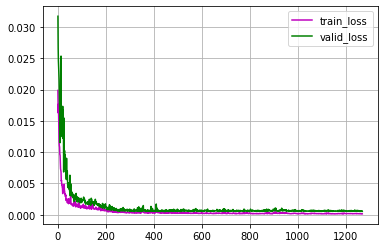

In [26]:
random_seed_set(0)
MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true = run_model_retraining()
print('MAPE:{:.6f},SMAPE:{:.6f},MAE:{:.6f},RMSE:{:.6f},RRSE:{:.6f},CORR:{:.6f}'.format(MAPE, SMAPE, MAE, RMSE, RRSE, CORR))

In [27]:
print('MAPE:{:.6f},SMAPE:{:.6f},MAE:{:.6f},RMSE:{:.6f},RRSE:{:.6f},CORR:{:.6f}'.format(MAPE, SMAPE, MAE, RMSE, RRSE, CORR))
np.save('./results/DARNet-BJ-72-24-TRUE-woCNN2D.npy', load_true)
np.save('./results/DARNet-BJ-72-24-PRED-woCNN2D.npy', load_pred)

MAPE:0.027844,SMAPE:0.027968,MAE:331.908198,RMSE:441.150970,RRSE:0.136950,CORR:255.998528


## figure plot

(0.0, 20210.192461723178)

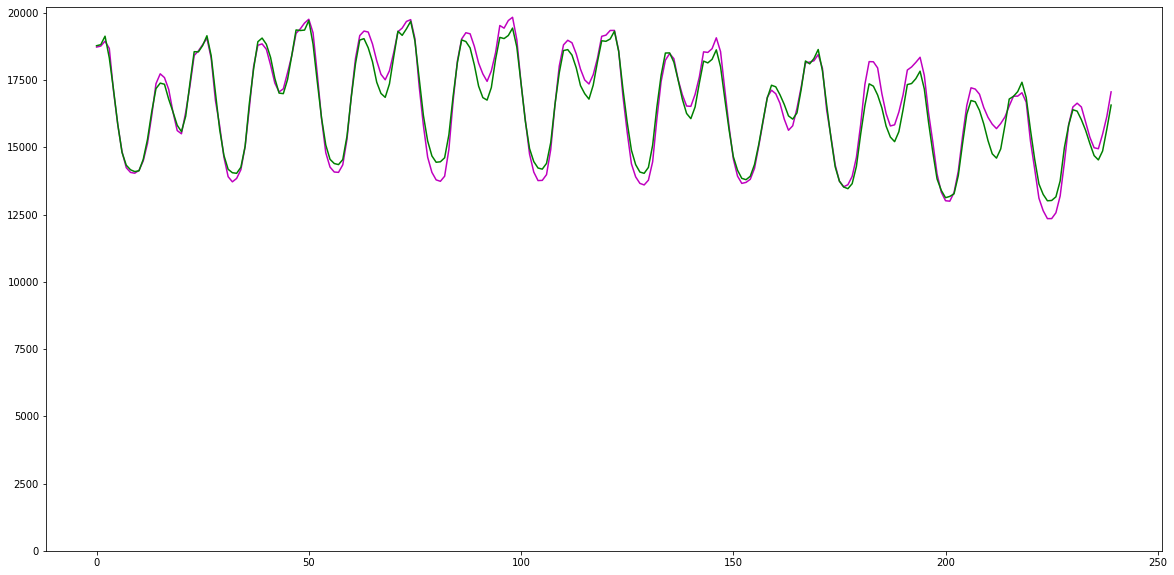

In [23]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[1000:1240, 23], 'm')
plt.plot(load_true[1000:1240, 23], 'g')
plt.ylim(ymin=0)